In [1]:
import os
import sys
import time
import json
import shutil
import warnings
warnings.filterwarnings('ignore')
import argparse
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, matthews_corrcoef
from imblearn.metrics import geometric_mean_score
from metrics import *
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from dataset import *
from utils import *
from models import *

# CoV-AbDab

In [2]:
cov = pd.read_csv("../SARS-SAbDab_Shaun/CoV-AbDab_extract.csv")
cov

,Index,AB_name,Class,Paratope,Epitope
0,1,m396,0,SYTWGGITILIANYQRDTVMGGSKWDSSDY,FSTFRGDEVRNNGQPTYGVGYQY
1,2,80R,0,SYAVISYDRDRSYDRVRSNDSTRSGSGSDFTTSRSW,RDVGGYNLYLFKGFNCYFLQSYGQPTYGVYQ
2,3,F26G19,0,YVSYTTYRYPGNDTTTEGIPQL,AFSTGDRWNNNPTYGVGYQY
3,4,1AF10,0,NWRENRYDPYYAMDIQHYQQTDSWPT,FIVKNKCVFTGVLTDIATDLDITPCSFGGSYQGVNRAGCIG
4,5,6D3,1,WHEDDYINYEYGLLAQNNFYTY,NVFAEHVNNSS
...,...,...,...,...,...
305,306,scFv_E4,1,VSGVTSSNYYPGGSYRDLSEKDVIQGISYSGQNS,RDQTGNDYYLFRKSNYQAGSTFNYFPLQSYGYGVGY
306,307,N3113,1,YEALEWSYHSRTYNPSWASGSTGDW,VATRFASYAWNKSKGGNYNYLRITEINGVKFLQS
307,308,N3113.1,1,QWYSRYNPSWASGST,ATRFASYANKDKVGNYNYLYITEINGVKFPLQSYG
308,309,RBD-chAb-15,1,GHWTTWGGSTNGYYV,YASFSTFKRGDRAWNTYGVGYQPY


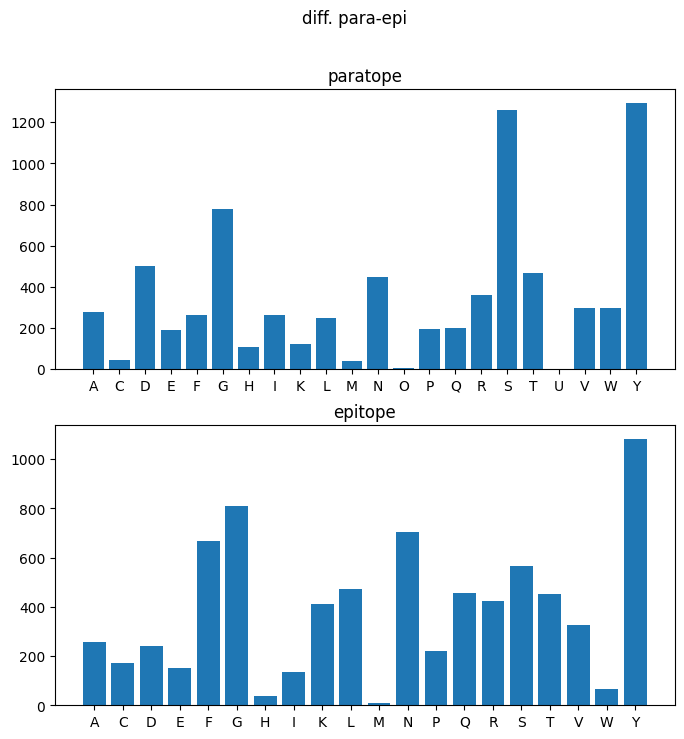

In [31]:
# difference between para and epi
stat_para = {}
stat_epi = {}

for i in range(len(cov)):
    
    paratope = cov["Paratope"].iloc[i]
    for aa in paratope:
        if aa in stat_para:
            stat_para[aa] += 1
        else:
            stat_para[aa] = 1
    
    epitope = cov["Epitope"].iloc[i]
    for aa in epitope:
        if aa in stat_epi:
            stat_epi[aa] += 1
        else:
            stat_epi[aa] = 1

li_para = [(k,stat_para[k]) for k in stat_para.keys()]
li_epi = [(k,stat_epi[k]) for k in stat_epi.keys()]

li_para = sorted(li_para, key=lambda x:x[0])
li_epi = sorted(li_epi, key=lambda x:x[0])

plt.figure(figsize=(8,8))

plt.subplot(211)
plt.title("paratope")
plt.bar(x=[i[0] for i in li_para], height=[i[1] for i in li_para])

plt.subplot(212)
plt.title("epitope")
plt.bar(x=[i[0] for i in li_epi], height=[i[1] for i in li_epi])

plt.suptitle("diff. para-epi")

plt.show()

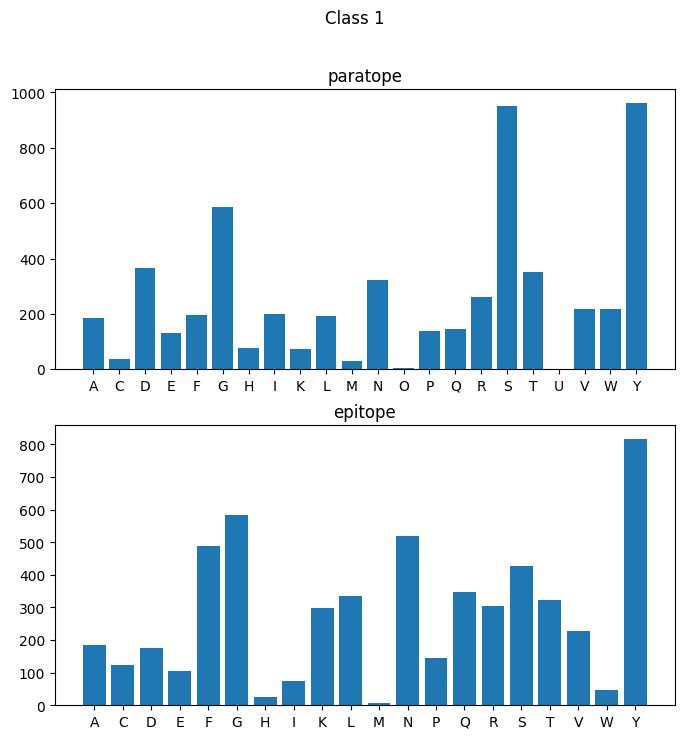

In [36]:
# difference between 1 and 0
stat_para1 = {}
stat_epi1 = {}

for i in range(len(cov)):
    
    if cov["Class"].iloc[i]==1:
    
        paratope = cov["Paratope"].iloc[i]
        for aa in paratope:
            if aa in stat_para1:
                stat_para1[aa] += 1
            else:
                stat_para1[aa] = 1

        epitope = cov["Epitope"].iloc[i]
        for aa in epitope:
            if aa in stat_epi1:
                stat_epi1[aa] += 1
            else:
                stat_epi1[aa] = 1

li_para1 = [(k,stat_para1[k]) for k in stat_para1.keys()]
li_epi1 = [(k,stat_epi1[k]) for k in stat_epi1.keys()]

li_para1 = sorted(li_para1, key=lambda x:x[0])
li_epi1 = sorted(li_epi1, key=lambda x:x[0])

plt.figure(figsize=(8,8))

plt.subplot(211)
plt.title("paratope")
plt.bar(x=[i[0] for i in li_para1], height=[i[1] for i in li_para1])

plt.subplot(212)
plt.title("epitope")
plt.bar(x=[i[0] for i in li_epi1], height=[i[1] for i in li_epi1])

plt.suptitle("Class 1")

plt.show()

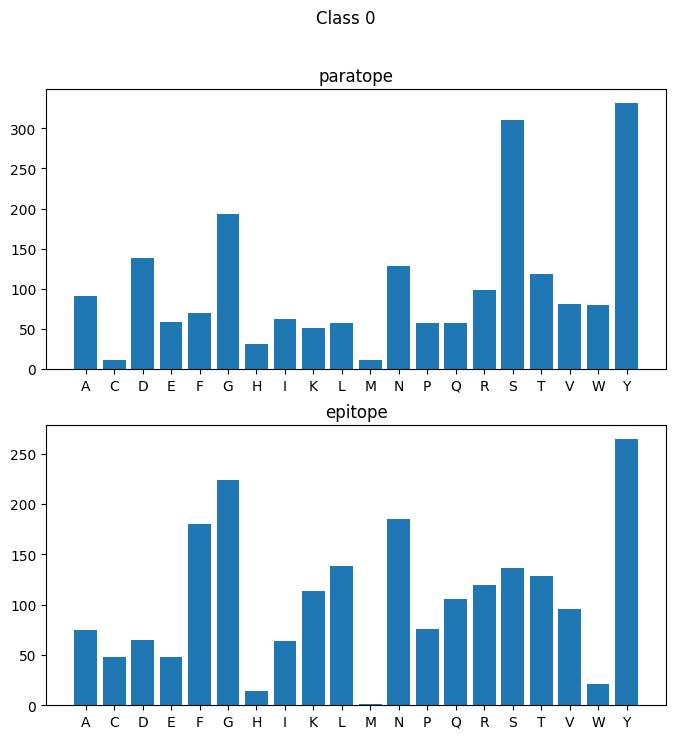

In [37]:
# difference between 1 and 0
stat_para0 = {}
stat_epi0 = {}

for i in range(len(cov)):
    
    if cov["Class"].iloc[i]==0:
    
        paratope = cov["Paratope"].iloc[i]
        for aa in paratope:
            if aa in stat_para0:
                stat_para0[aa] += 1
            else:
                stat_para0[aa] = 1

        epitope = cov["Epitope"].iloc[i]
        for aa in epitope:
            if aa in stat_epi0:
                stat_epi0[aa] += 1
            else:
                stat_epi0[aa] = 1

li_para0 = [(k,stat_para0[k]) for k in stat_para0.keys()]
li_epi0 = [(k,stat_epi0[k]) for k in stat_epi0.keys()]

li_para0 = sorted(li_para0, key=lambda x:x[0])
li_epi0 = sorted(li_epi0, key=lambda x:x[0])

plt.figure(figsize=(8,8))

plt.subplot(211)
plt.title("paratope")
plt.bar(x=[i[0] for i in li_para0], height=[i[1] for i in li_para0])

plt.subplot(212)
plt.title("epitope")
plt.bar(x=[i[0] for i in li_epi0], height=[i[1] for i in li_epi0])

plt.suptitle("Class 0")

plt.show()

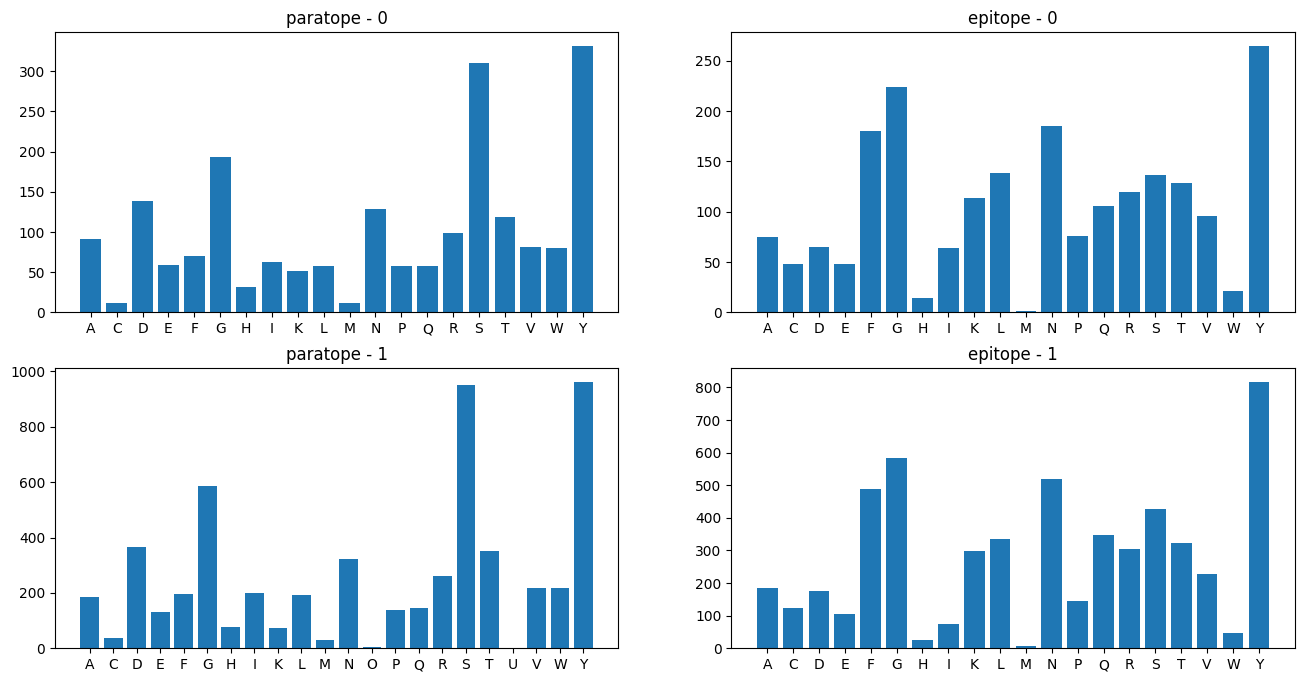

In [40]:
plt.figure(figsize=(16,8))

plt.subplot(221)
plt.title("paratope - 0")
plt.bar(x=[i[0] for i in li_para0], height=[i[1] for i in li_para0])

plt.subplot(222)
plt.title("epitope - 0")
plt.bar(x=[i[0] for i in li_epi0], height=[i[1] for i in li_epi0])

# plt.suptitle("Class 0")

plt.subplot(223)
plt.title("paratope - 1")
plt.bar(x=[i[0] for i in li_para1], height=[i[1] for i in li_para1])

plt.subplot(224)
plt.title("epitope - 1")
plt.bar(x=[i[0] for i in li_epi1], height=[i[1] for i in li_epi1])

# plt.suptitle("Class 0")

plt.show()

In [22]:
part = cov.sample(frac=0.1, random_state=42)
data_df = cov.drop(part.index)
data_df

,Index,AB_name,Class,Paratope,Epitope
0,1,m396,0,SYTWGGITILIANYQRDTVMGGSKWDSSDY,FSTFRGDEVRNNGQPTYGVGYQY
1,2,80R,0,SYAVISYDRDRSYDRVRSNDSTRSGSGSDFTTSRSW,RDVGGYNLYLFKGFNCYFLQSYGQPTYGVYQ
2,3,F26G19,0,YVSYTTYRYPGNDTTTEGIPQL,AFSTGDRWNNNPTYGVGYQY
3,4,1AF10,0,NWRENRYDPYYAMDIQHYQQTDSWPT,FIVKNKCVFTGVLTDIATDLDITPCSFGGSYQGVNRAGCIG
4,5,6D3,1,WHEDDYINYEYGLLAQNNFYTY,NVFAEHVNNSS
...,...,...,...,...,...
304,305,XG014,1,NWTSLSWYDDTRYQYGYNYGYF,FGFNTRVLSASFWNSNNLDSKVNPTR
305,306,scFv_E4,1,VSGVTSSNYYPGGSYRDLSEKDVIQGISYSGQNS,RDQTGNDYYLFRKSNYQAGSTFNYFPLQSYGYGVGY
306,307,N3113,1,YEALEWSYHSRTYNPSWASGSTGDW,VATRFASYAWNKSKGGNYNYLRITEINGVKFLQS
308,309,RBD-chAb-15,1,GHWTTWGGSTNGYYV,YASFSTFKRGDRAWNTYGVGYQPY


In [25]:
data_df.iloc[311]["Class"]==1

IndexError: single positional indexer is out-of-bounds

In [19]:
cov.iloc[0]["Class"]==1

False

In [18]:
part = cov.sample(frac=0.1, random_state=42)
part.shape

(31, 5)

In [7]:
len(cov[cov["Class"]==1]["Paratope"].unique()), len(cov[cov["Class"]==1]["Epitope"].unique())

(228, 226)

In [10]:
len(cov[cov["Class"]==1]), len(cov[cov["Class"]==0])

(228, 82)

228 unique paratopes, 226 unique epitopes, 228 binding pairs, 82 non-binding pairs

In [15]:
228+225*9

2253

# SAbDab

In [43]:
sabdab = pickle.load(open("./data/processed_data_clip1_neg0_usepairFalse_num_neg1.pkl", "rb"))
len(sabdab)

7558

In [44]:
sabdab[0]

('GGSISSGDSY/IYYSGST/ARHVGDLRVNDAFDI/SSNIGNNF/DSD/GTWDRSLSVVV',
 'MEVSYCYEASISDFACSKKMTGKLTMNNKHPWHAADTGTPHWMDGAKG########################',
 1)

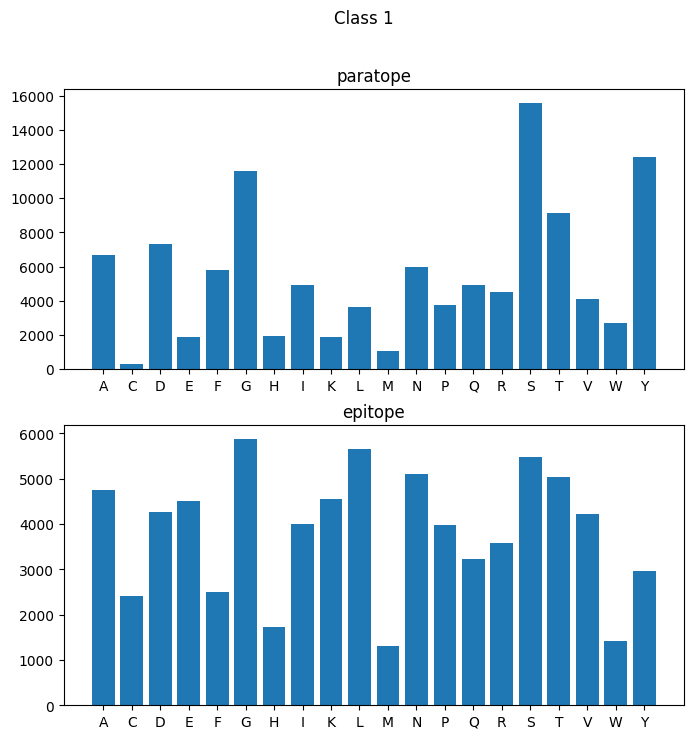

In [50]:
# difference between 1 and 0
stat_para1 = {}
stat_epi1 = {}

for i in range(len(sabdab)):
    
    if sabdab[i][2]==1:
    
        paratope = sabdab[i][0]
        for aa in paratope:
            if aa!="#" and aa!="/" and aa!="*":
                if aa in stat_para1:
                    stat_para1[aa] += 1
                else:
                    stat_para1[aa] = 1

        epitope = sabdab[i][1]
        for aa in epitope:
            if aa!="#" and aa!="/" and aa!="*":
                if aa in stat_epi1:
                    stat_epi1[aa] += 1
                else:
                    stat_epi1[aa] = 1

li_para1 = [(k,stat_para1[k]) for k in stat_para1.keys()]
li_epi1 = [(k,stat_epi1[k]) for k in stat_epi1.keys()]

li_para1 = sorted(li_para1, key=lambda x:x[0])
li_epi1 = sorted(li_epi1, key=lambda x:x[0])

plt.figure(figsize=(8,8))

plt.subplot(211)
plt.title("paratope")
plt.bar(x=[i[0] for i in li_para1], height=[i[1] for i in li_para1])

plt.subplot(212)
plt.title("epitope")
plt.bar(x=[i[0] for i in li_epi1], height=[i[1] for i in li_epi1])

plt.suptitle("Class 1")

plt.show()

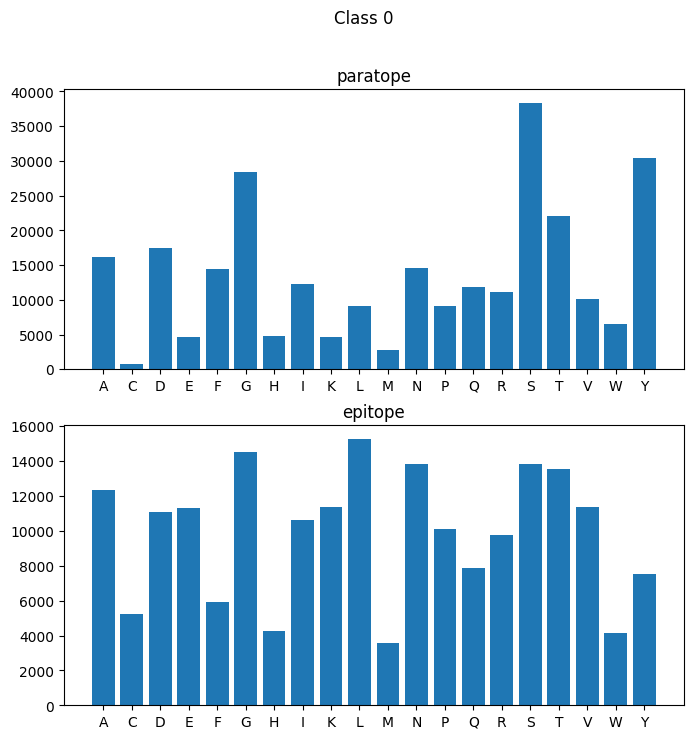

In [51]:
# difference between 1 and 0
stat_para0 = {}
stat_epi0 = {}

for i in range(len(sabdab)):
    
    if sabdab[i][2]==0:
    
        paratope = sabdab[i][0]
        for aa in paratope:
            if aa!="#" and aa!="/" and aa!="*":
                if aa in stat_para0:
                    stat_para0[aa] += 1
                else:
                    stat_para0[aa] = 1

        epitope = sabdab[i][1]
        for aa in epitope:
            if aa!="#" and aa!="/" and aa!="*":
                if aa in stat_epi0:
                    stat_epi0[aa] += 1
                else:
                    stat_epi0[aa] = 1

li_para0 = [(k,stat_para0[k]) for k in stat_para0.keys()]
li_epi0 = [(k,stat_epi0[k]) for k in stat_epi0.keys()]

li_para0 = sorted(li_para0, key=lambda x:x[0])
li_epi0 = sorted(li_epi0, key=lambda x:x[0])

plt.figure(figsize=(8,8))

plt.subplot(211)
plt.title("paratope")
plt.bar(x=[i[0] for i in li_para0], height=[i[1] for i in li_para0])

plt.subplot(212)
plt.title("epitope")
plt.bar(x=[i[0] for i in li_epi0], height=[i[1] for i in li_epi0])

plt.suptitle("Class 0")

plt.show()

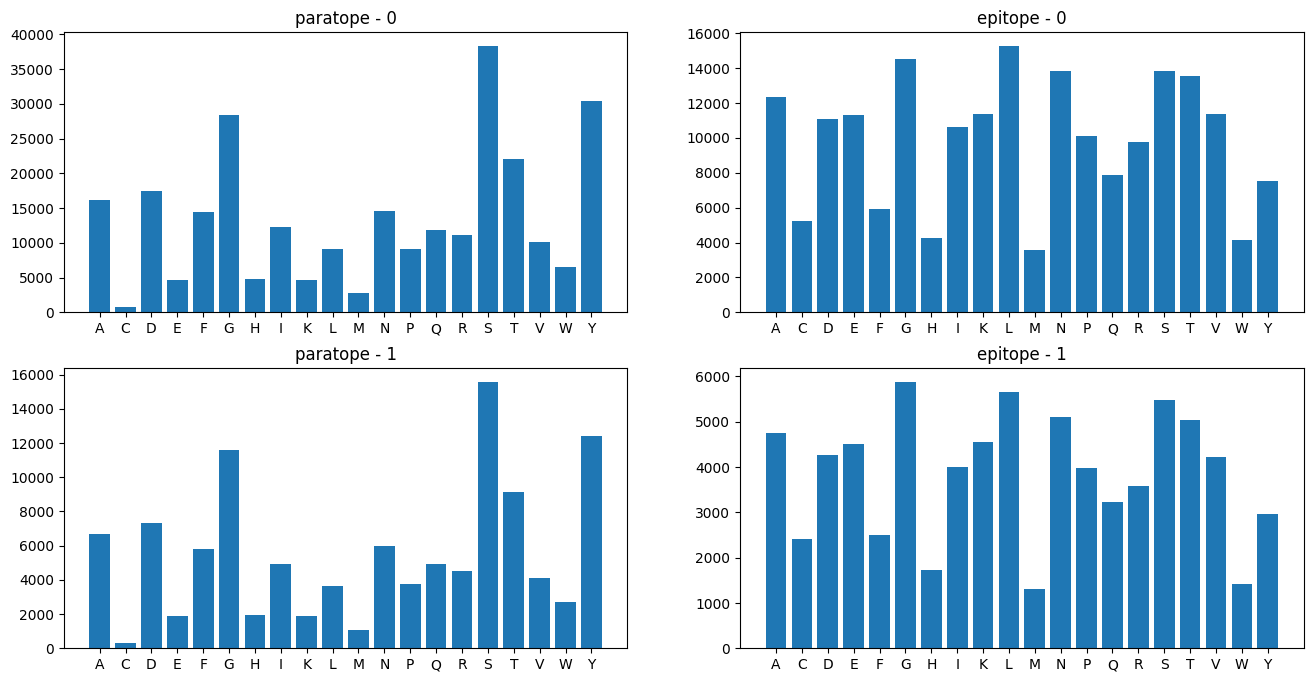

In [52]:
plt.figure(figsize=(16,8))

plt.subplot(221)
plt.title("paratope - 0")
plt.bar(x=[i[0] for i in li_para0], height=[i[1] for i in li_para0])

plt.subplot(222)
plt.title("epitope - 0")
plt.bar(x=[i[0] for i in li_epi0], height=[i[1] for i in li_epi0])

# plt.suptitle("Class 0")

plt.subplot(223)
plt.title("paratope - 1")
plt.bar(x=[i[0] for i in li_para1], height=[i[1] for i in li_para1])

plt.subplot(224)
plt.title("epitope - 1")
plt.bar(x=[i[0] for i in li_epi1], height=[i[1] for i in li_epi1])

# plt.suptitle("Class 0")

plt.show()

In [60]:
aas_cov = {}
aas_sabdab = {}

for i in range(len(cov)):
#     for aa in cov["Paratope"].iloc[i]:
#         if aa!="#" and aa!="/" and aa!="*":
#             if aa in aas_cov:
#                 aas_cov[aa] += 1
#             else:
#                 aas_cov[aa] = 1
                
    for aa in cov["Epitope"].iloc[i]:
        if aa!="#" and aa!="/" and aa!="*":
            if aa in aas_cov:
                aas_cov[aa] += 1
            else:
                aas_cov[aa] = 1

In [61]:
for i in range(len(sabdab)):
#     for aa in sabdab[i][0]:
#         if aa!="#" and aa!="/" and aa!="*":
#             if aa in aas_sabdab:
#                 aas_sabdab[aa] += 1
#             else:
#                 aas_sabdab[aa] = 1
                
    for aa in sabdab[i][1]:
        if aa!="#" and aa!="/" and aa!="*":
            if aa in aas_sabdab:
                aas_sabdab[aa] += 1
            else:
                aas_sabdab[aa] = 1

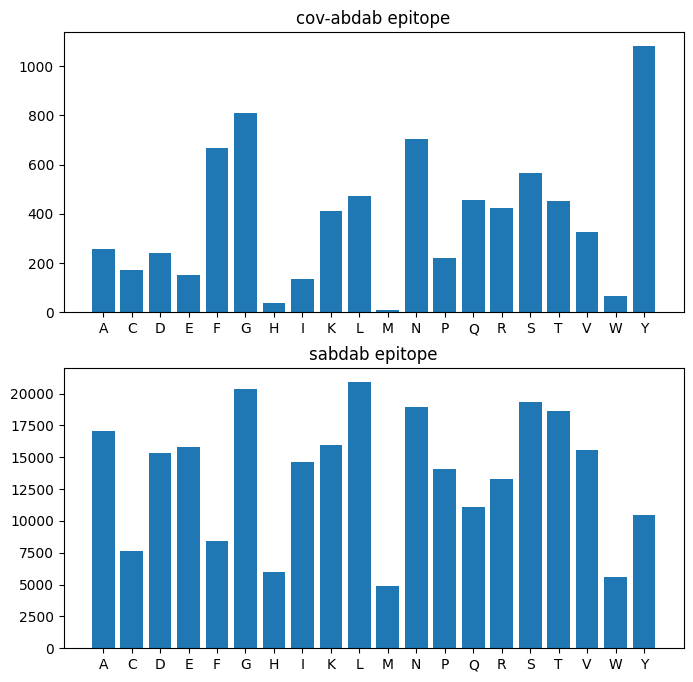

In [62]:
li_cov = [(k,aas_cov[k]) for k in aas_cov.keys()]
li_sabdab = [(k,aas_sabdab[k]) for k in aas_sabdab.keys()]

li_cov = sorted(li_cov, key=lambda x:x[0])
li_sabdab = sorted(li_sabdab, key=lambda x:x[0])

plt.figure(figsize=(8,8))

plt.subplot(211)
plt.title("cov-abdab epitope")
plt.bar(x=[i[0] for i in li_cov], height=[i[1] for i in li_cov])

plt.subplot(212)
plt.title("sabdab epitope")
plt.bar(x=[i[0] for i in li_sabdab], height=[i[1] for i in li_sabdab])

plt.show()

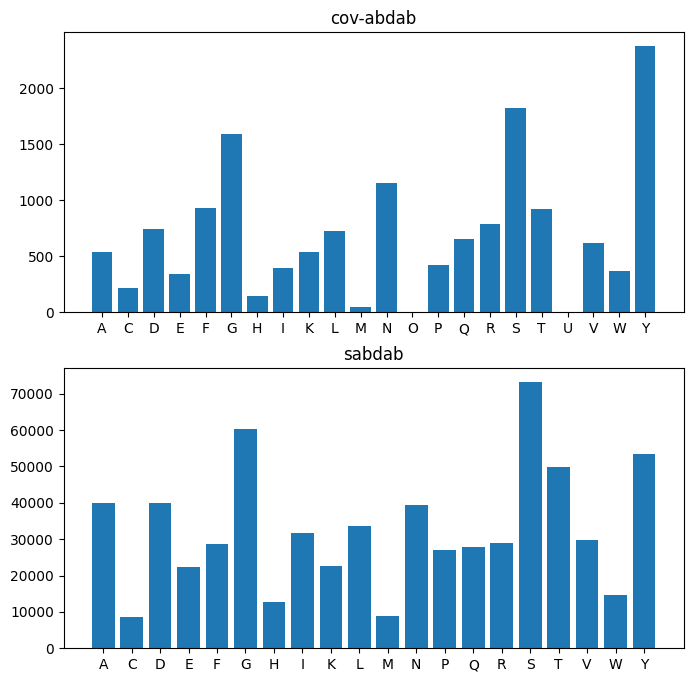

In [59]:
li_cov = [(k,aas_cov[k]) for k in aas_cov.keys()]
li_sabdab = [(k,aas_sabdab[k]) for k in aas_sabdab.keys()]

li_cov = sorted(li_cov, key=lambda x:x[0])
li_sabdab = sorted(li_sabdab, key=lambda x:x[0])

plt.figure(figsize=(8,8))

plt.subplot(211)
plt.title("cov-abdab")
plt.bar(x=[i[0] for i in li_cov], height=[i[1] for i in li_cov])

plt.subplot(212)
plt.title("sabdab")
plt.bar(x=[i[0] for i in li_sabdab], height=[i[1] for i in li_sabdab])

plt.show()